### 해결해야 하는 문제

-     test.zip 파일 각각 픽셀별 강수량 산출



### 데이터 설명

-     GPM(Global Precipitation Measurement) Core 위성의 GMI/DPR 센서에서 북서태평양영역 (육지와 바다를 모두 포함) 에서 관측된 자료

-     특정 orbit에서 기록된 자료를 40 X 40 형태로 분할(subset) 하여 제공

-     subset_######_##.npy 파일로 제공되며, (height, width, channel) 형태

-     \###### : 위성이 사용되기 시작한 이후로 몇 번째 지구를 돌았는지 나타내는 수(orbit 번호)

-     \##: 해당 orbit에서 몇 번째 subset인지를 나타내는 수입니다. orbit별로 subset의 개수는 다를 수 있음 (subset 번호)

-     데이터 출처 및 기타 세부사항은 토론 게시판의 pdf 자료 및 영상 자료 확인

-     pdf자료: https://dacon.io/competitions/official/235591/talkboard/400589

-     영상자료: https://dacon.io/competitions/official/235591/talkboard/400598



train.zip

-     2016~2018 년 관측된 자료 (76,345개)

-     2016년 자료: orbit 번호 010462 ~ 016152 (25,653개)

-     2017년 자료: orbit 번호 016154 ~ 021828 (25,197개)

-     2018년 자료: orbit 번호 021835 ~ 027509 (25,495개)



test.zip 

-     2019년 관측된 자료 (2,416개)



sample_submission.csv

-     제출 양식 예시

-     시각화 참조: https://dacon.io/competitions/official/235591/talkboard/400629

---
---

# 1. 라이브러리

In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, concatenate, Input
from tensorflow.keras import Model
import warnings
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

## 2. 데이터 불러오기

In [2]:
path = 'C:/Users/qudgu/ByungHyun_Dacon/'
use_col_num = 10

train_path = path + 'train'
train_files = sorted(glob.glob(train_path + '/*'))

test_path = path + 'test'
test_files = sorted(glob.glob(test_path + '/*'))

submission = pd.read_csv(path + 'sample_submission.csv')

In [3]:
train = []
for file in tqdm(train_files):
    try:
        data = np.load(file).astype('float32')
        train.append(data)
    except:
        continue

100%|███████████████████████████████████████████████████████████████████████████| 76345/76345 [09:13<00:00, 137.84it/s]


In [4]:
test = []
for file in tqdm(test_files):
    data = np.load(file).astype('float32')
    test.append(data)

100%|█████████████████████████████████████████████████████████████████████████████| 2416/2416 [00:18<00:00, 128.06it/s]


In [5]:
train = np.array(train)
test = np.array(test)

In [6]:
print(train.shape)
print(test.shape)

(76345, 40, 40, 15)
(2416, 40, 40, 14)


---
---

# 3. 시각화를 통한 탐색적 분석(EDA)

##### 강수량  시각화를 위한 데이터 추출

In [7]:
image_sample_rain = train[((train[:,:,:,-1].reshape(-1,40*40,1)>0).sum(axis=1)>=100).flatten()][:5,:,:,:]
image_sample_no_rain = train[((train[:,:,:,-1].reshape(-1,40*40,1)>0).sum(axis=1)==0).flatten()][:5,:,:,:]

print(image_sample_rain.shape)
print(image_sample_no_rain.shape)

(5, 40, 40, 15)
(5, 40, 40, 15)


>- image_sample_rain : 40X40 픽셀,즉 1600개 픽셀중에서 각 픽셀별로 비가 온 픽셀이 100개이상인 5개의 관측자료를 시각화를 위해 추출
>- image_sample_no_rain : 위와 비슷한 원리로 , 1600개 픽셀중 모든 픽셀이 강수량이 없는 5개의 관측자료 추출

#### - 각 밝기온도(ch1~ch9)와 강수량의 상관관계를 시각화를 통해 확인

In [8]:
# 더 두드러진 시각화를 위해 Red, Blue로 색채대비를 활용
color_map = plt.cm.get_cmap('RdBu')   
color_map = color_map.reversed()      

In [9]:
def show_image(image_sample):
    for row in range(5):
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(30, 30))
        
        
        for i in range(9):
            
            plt.subplot(1,10,i+1)
            plt.imshow(image_sample[row,:,:,i], cmap=color_map)
            plt.title('ch%d'%(i+1))
            plt.axis('off')

            
        plt.subplot(1,10,10)
        plt.imshow(image_sample[row,:,:,-1], cmap = color_map)
        plt.title('precipitation')
        plt.axis('off')
        plt.show()

##### 비가 많이 온 지역의 ch와 강수량 시각화

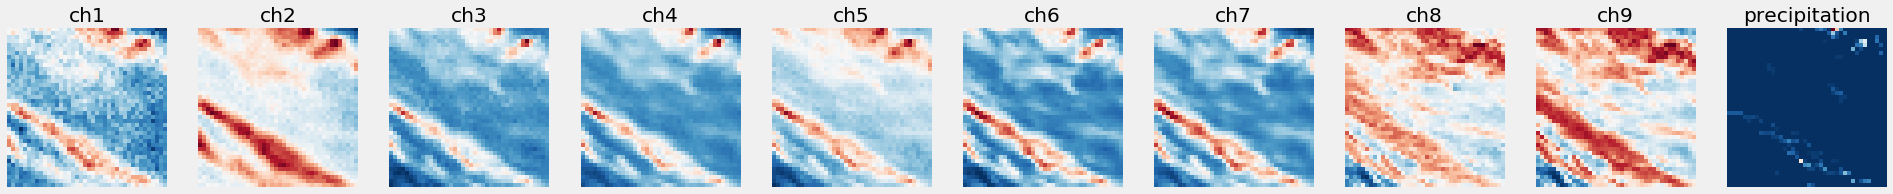

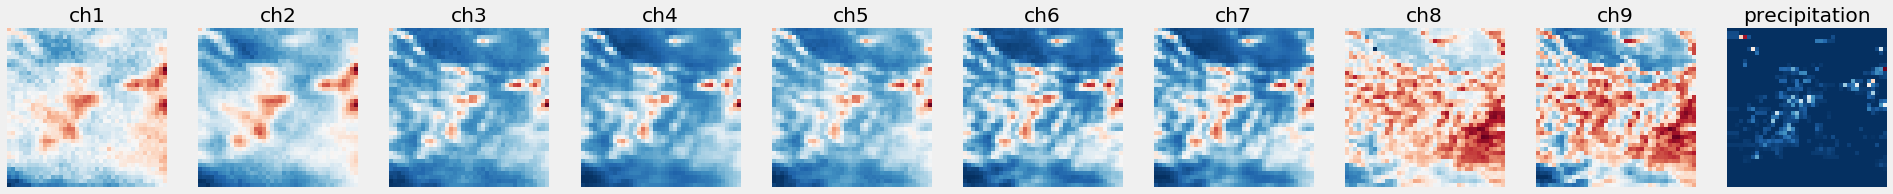

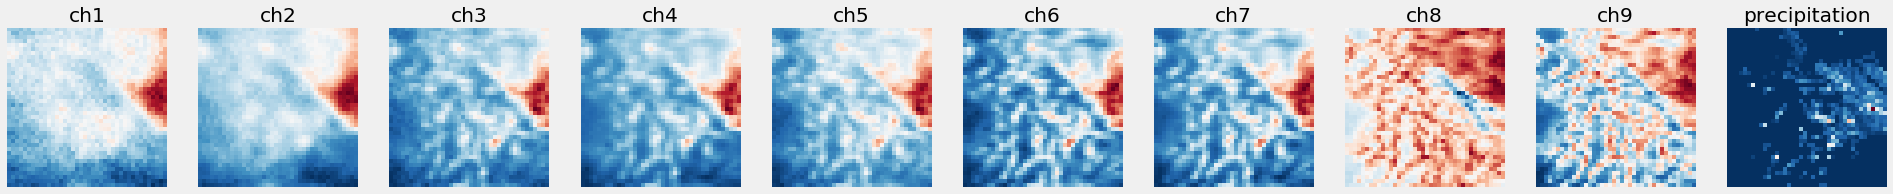

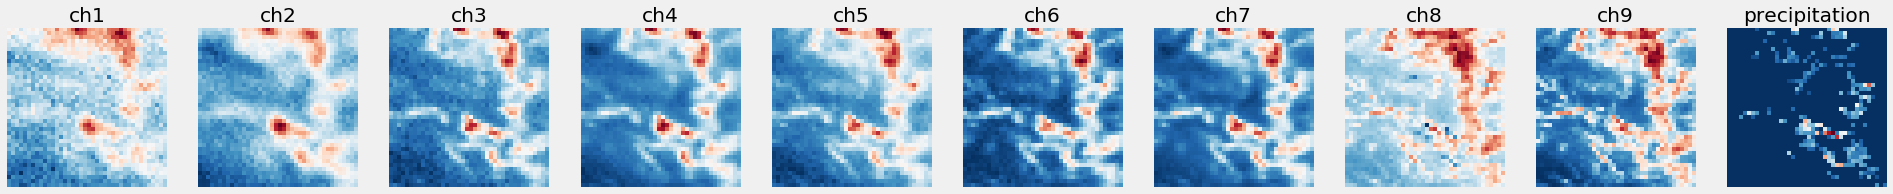

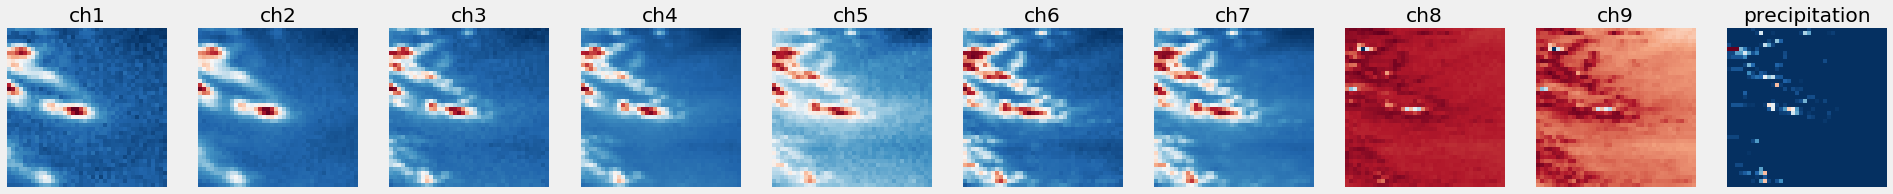

In [10]:
show_image(image_sample_rain)

>- 강수량과 빛의밝기는 상관관계가 존재한다는 것을 알 수 있다.

##### 비가 전혀 오지 않은 지역에 대한 ch와 강수량 시각화

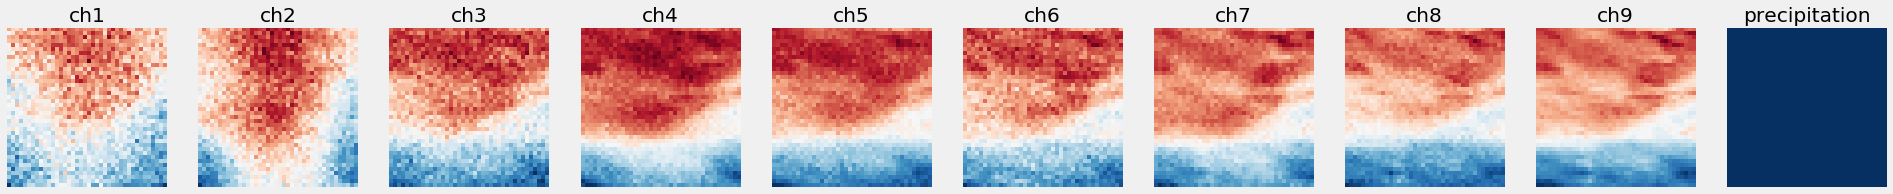

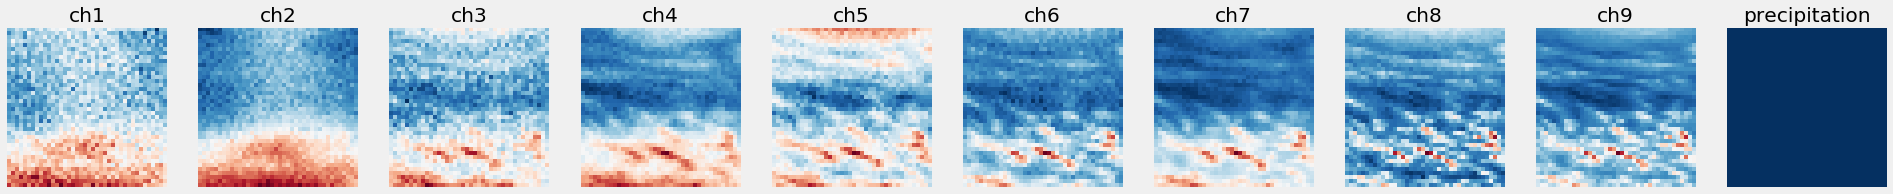

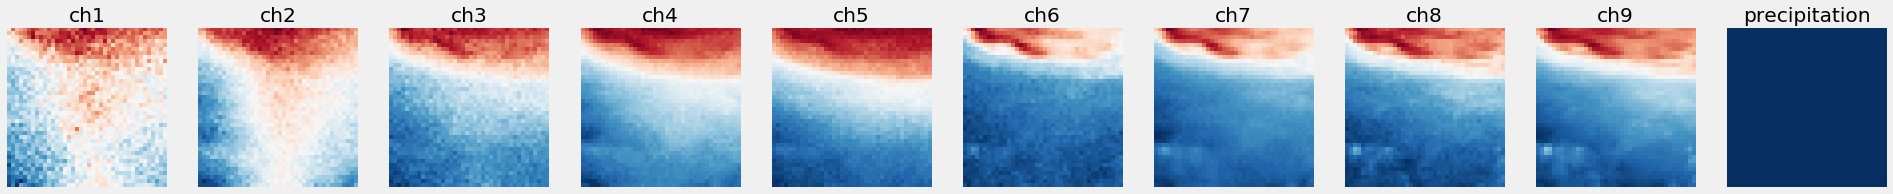

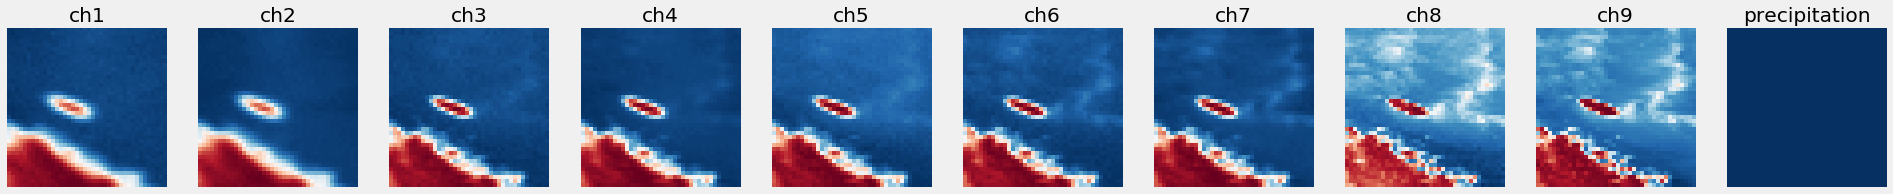

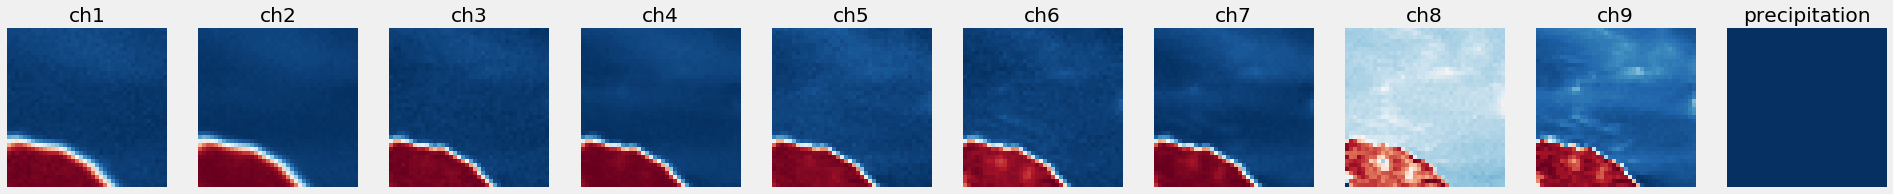

In [11]:
show_image(image_sample_no_rain)

>- 각 ch별로 특성이 다르지만, 비교적 상관관계가 있음을 볼 수 있다.
>- 비가 많이 온 지역은 밝기온도의 데이터가 고르지 않으며 , 비가 오지않은 지역은 데이터가 비교적 고르게 분포된 편이다.

In [12]:
del image_sample_no_rain
del image_sample_rain

### DPR 위도와 경도 시각화

In [13]:
train_GMI_long = train[range(0, 76345 , 30),0,0,10]; train_DPR_long = train[range(0, 76345 , 30),0,0,12]
train_GMI_lat = train[range(0, 76345 , 30),0,0,11] ; train_DPR_lat = train[range(0, 76345 , 30),0,0,13]

test_GMI_long = test[:,0,0,10] ; test_DPR_long = test[:,0,0,12]
test_GMI_lat = test[:,0,0,11]; test_DPR_lat = test[:,0,0,13]

print(train_DPR_long.shape)
print(test_DPR_long.shape)

(2545,)
(2416,)


>- 76345의 데이터를 모두 시각화하기엔 많아서 , train과 test데이터의 비중을 맞춰줌

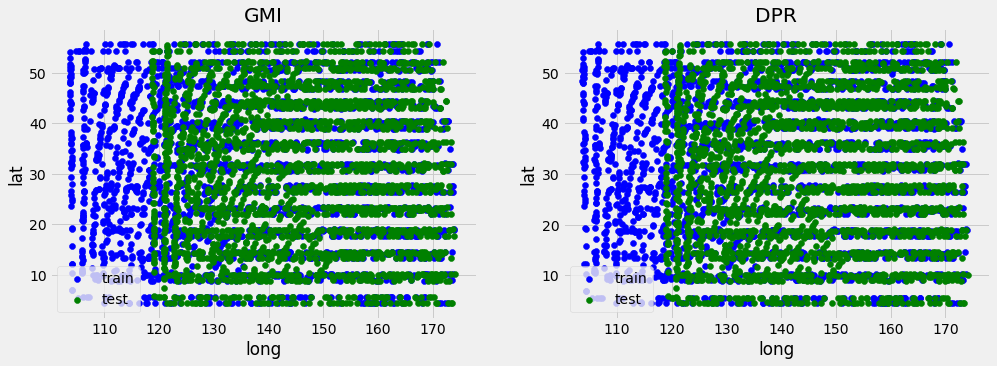

test_GMI_long 최소값 :  118.6669
test_DPR_long 최소값 :  118.646935


In [14]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.scatter(train_GMI_long , train_GMI_lat , color = 'blue', label = 'train')
plt.scatter(test_GMI_long , test_GMI_lat , color = 'green', label = 'test')
plt.title('GMI') ; plt.ylabel('lat'); plt.xlabel('long')
plt.legend()

plt.subplot(1,2,2)
plt.scatter(train_DPR_long , train_DPR_lat , color = 'blue', label = 'train')
plt.scatter(test_DPR_long , test_DPR_lat , color = 'green', label = 'test')
plt.title('DPR') ; plt.ylabel('lat'); plt.xlabel('long')
plt.legend()
plt.show()


min_DPR_long = test_DPR_long.min()

print('test_GMI_long 최소값 : ', test_GMI_long.min())
print('test_DPR_long 최소값 : ', test_DPR_long.min())

>- DPR위도와 DPR 경도를 train과 test별 시각화
>- 데이터의 수도 상당히 많고 , test에 최대한 적합시키기위해 test데이터의 최소 longitude 이하인 값들은 제거

# 4. 데이터 추출하기

##### DPR 위도 기준으로 , test데이터에 최대한 적합시키는 과정

In [15]:
train = train[((train[:,:,:,12].reshape(-1,40*40,1)).mean(axis=1)>min_DPR_long).flatten()]

print(train.shape)  #76345->61480으로 축소

(61480, 40, 40, 15)


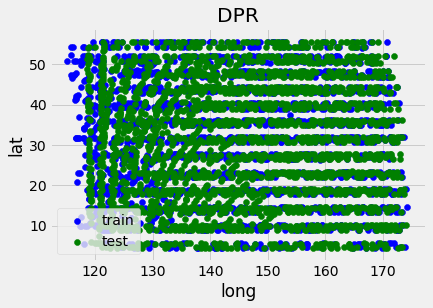

In [16]:
train_DPR_long = train[range(0, 61480 , 30),0,0,12]
train_DPR_lat = train[range(0, 61480 , 30),0,0,13]

plt.subplot(1,1,1)
plt.scatter(train_DPR_long , train_DPR_lat , color = 'blue', label = 'train')
plt.scatter(test_DPR_long , test_DPR_lat , color = 'green', label = 'test')
plt.title('DPR') ; plt.ylabel('lat'); plt.xlabel('long')
plt.legend()
plt.show()

>- train과 test데이터의 DPR위도가 비교적 비슷해졌음을 확인 할 수 있다. 
>- train 데이터는 76345->61480으로 축소되엇다.

In [17]:
del train_DPR_long,  train_DPR_lat, train_GMI_long, train_GMI_lat, \
        test_DPR_lat, test_DPR_long, test_GMI_lat, test_GMI_long

### 강수량의 결측치 제거
- 데이터 설명에 강수량의 결측치는 -9999로 관측되었다고 함.
- 강수량이 0 미만인 값은 모두 결측치라 생각한 후 제거시킬것

In [18]:
train = train[((train[:,:,:,-1].reshape(-1,40*40,1)<0).sum(axis=1)==0).flatten()]

print(train.shape)  

(61148, 40, 40, 15)


>- 40X40 픽셀 중 , 강수량이 0 미만인 것이 한개라도 존재하지 않는 행만 사용
>- 즉 , 1600개 픽셀중 결측치 하나라도 있는 행 제거
>- 데이터의 개수는 61480 => 61148 , 즉 결측치가 존재하는 332개의 행이 제거됨

### 비가 내린 셀이50개 이상인 것만 추출
- 모두 사용하면 학습결과는 좋아지겠지만 , 데이터셋이 너무 많음.
- 데이터의 수를 줄이고자 1600개의 픽셀중에서 비가 내린 셀이 50개 이상인 데이터만 사용하기로 함

In [20]:
train = train[((train[:,:,:,-1].reshape(-1,40*40,1)>0).sum(axis=1)>=50).flatten()]

print(train.shape)

(26447, 40, 40, 15)


# 데이터 나누기

##### 학습 데이터 선택
- 1\~10 채널만 학습에 사용 , 즉 ch1~ch9 + 지표 형태만 학습에 사용함

In [21]:
x_train = train[:,:,:,:10]
y_train = train[:,:,:,-1]
test = test[:,:,:,:10]


y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], y_train.shape[2], 1) 
# (26447, 40 , 40 ) => (26447, 40 , 40, 1)


del train

# 데이터 부풀리기

In [23]:
def data_generator(x_train, y_train):
#     rotate_X_90 = np.zeros_like(x_train)
#     rotate_Y_90 = np.zeros_like(y_train)

#     for j in range(rotate_X_90.shape[0]):
#         rotate_x=np.zeros([x_train.shape[1],x_train.shape[2],10])
#         rotate_y=np.zeros([x_train.shape[1],x_train.shape[2],1])
#         for i in range(10):
#             rotate_x[:,:,i]=np.rot90(x_train[j,:,:,i])
#         rotate_y[:,:,0]=np.rot90(y_train[j,:,:,0])

#         rotate_X_90[j,:,:,:] = rotate_x
#         rotate_Y_90[j,:,:,:] = rotate_y

    rotate_X_180 = np.zeros_like(x_train)
    rotate_Y_180 = np.zeros_like(y_train)

    for j in range(rotate_X_180.shape[0]):
        rotate_x=np.zeros([x_train.shape[1],x_train.shape[2],10])
        rotate_y=np.zeros([x_train.shape[1],x_train.shape[2],1])
        for i in range(10):
            rotate_x[:,:,i]=np.rot90(x_train[j,:,:,i])
            rotate_x[:,:,i]=np.rot90(rotate_x[:,:,i])
        rotate_y[:,:,0]=np.rot90(y_train[j,:,:,0])
        rotate_y[:,:,0]=np.rot90(rotate_y[:,:,0])

        rotate_X_180[j,:,:,:] = rotate_x
        rotate_Y_180[j,:,:,:] = rotate_y

#     rotate_X_270 = np.zeros_like(x_train)
#     rotate_Y_270 = np.zeros_like(y_train)

#     for j in range(rotate_X_270.shape[0]):
#         rotate_x=np.zeros([x_train.shape[1],x_train.shape[2],10])
#         rotate_y=np.zeros([x_train.shape[1],x_train.shape[2],1])
#         for i in range(10):
#             rotate_x[:,:,i]=np.rot90(x_train[j,:,:,i])
#             rotate_x[:,:,i]=np.rot90(rotate_x[:,:,i])
#             rotate_x[:,:,i]=np.rot90(rotate_x[:,:,i])
#         rotate_y[:,:,0]=np.rot90(y_train[j,:,:,0])
#         rotate_y[:,:,0]=np.rot90(rotate_y[:,:,0])
#         rotate_y[:,:,0]=np.rot90(rotate_y[:,:,0])

#         rotate_X_270[j,:,:,:] = rotate_x
#         rotate_Y_270[j,:,:,:] = rotate_y

    #x_train = np.concatenate((x_train, rotate_X_90, rotate_X_180, rotate_X_270), axis = 0)
    #y_train = np.concatenate((y_train, rotate_Y_90, rotate_Y_180, rotate_Y_270), axis = 0)
    
    x_train = np.concatenate((x_train, rotate_X_180), axis = 0)
    y_train = np.concatenate((y_train, rotate_Y_180), axis = 0)
    
    
    del rotate_X_180

    x_T = np.zeros_like(x_train)
    y_T = np.zeros_like(y_train)

    for i in range(x_train.shape[0]):
        for j in range(x_train.shape[3]):
            x_T[i,:,:,j] = x_train[i,:,:,j].T
        y_T[i,:,:,0] = y_train[i,:,:,0].T

    x_train = np.concatenate((x_train, x_T), axis = 0)
    y_train = np.concatenate((y_train, y_T), axis = 0)

    del x_T,y_T
    
    return x_train, y_train

>- 메모리 부족으로 , 180도만 회전시킴
>- 만약 다양한 각도로 회전을 시킨다면 더 좋은 성능을 기대 할 수 있을것

##### 회전 데이터 생성

In [24]:
x_train, y_train= data_generator(x_train , y_train)

x_train.shape

****
****

# 5. 모델링 및 성능 점검 

### # 평가 지표

In [26]:
from sklearn.metrics import f1_score

def mae(y_true, y_pred) :
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    over_threshold = y_true >= 0.1
    
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    remove_NAs = y_true >= 0
    
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def maeOverFscore_keras(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

>- 실제값과 예측값의 차이가 0.1이면 1, 아니면 0으로 분류하게 하여 , f1score로 채점함
>- $f1score = \frac{precision * recall}{precision+recall} $
    - precision : 정확도
    - recall : 재현율
>- 최종 채점 평가 지표는 maeOverFscore_keras
$$maeOverFscore_keras = \frac{mae(true, pred)}{f1score(true, pred)}$$

In [27]:
def create_model():
    inputs=Input((40, 40, 10))
    
    bn=BatchNormalization()(inputs)
    conv0=Conv2D(64, kernel_size=1, strides=1, padding='same', activation='relu')(bn)
    
    bn=BatchNormalization()(conv0)
    conv=Conv2D(32, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    concat=concatenate([conv0, conv], axis=3)
    
    bn=BatchNormalization()(concat)
    conv=Conv2D(16, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
    concat=concatenate([concat, conv], axis=3)
        
    for i in range(2): 
        bn=BatchNormalization()(concat)
        conv=Conv2D(8, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
        concat=concatenate([concat, conv], axis=3)
    
    bn=BatchNormalization()(concat)
    outputs=Conv2D(1, kernel_size=1, strides=1, padding='same', activation='relu')(bn)
    
    model=Model(inputs=inputs, outputs=outputs)
    
    return model

model = create_model()

>- resnet 기반의 CNN 모델 사용
>- 데이콘 공개 코드를 참고하여 모델링을 함

In [28]:
model.compile(loss='mae', optimizer='adam', metrics=[maeOverFscore_keras, fscore_keras])

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40, 40, 10)] 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 40, 40, 10)   40          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 40, 40, 64)   704         batch_normalization[0][0]        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 40, 40, 64)   256         conv2d[0][0]                     
______________________________________________________________________________________________

In [30]:
callbacks_list = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',        #val_loss는 위의 metrics로 설정한 maeOverFscore_keras,fscore_keras 둘다 적절히 조화된 값인듯
        patience=3,
        factor=0.2,
        min_lr=0.000001
    ),

    EarlyStopping(monitor='val_loss', patience=10)
]

>- ##### ReduceLROnPlateau
    - patience : 연속 3개이상 좋은 효과가 나타나지 않으면 learning_rate를 감소시키는 과정
    - 그 기준은 maeOverFscore_keras, fscore_keras를 평가대상으로한 train의 val_loss를 기준으로함
    - 그때 learning_rate는 기존의 lr의 0.3배를 해줌
    - 그때 최소 learning_rate는 0.000001로 둘것
>- ##### EarlyStopping
    - val_loss가 증가하는 시점으로 부터 10번째 이후까지 학습에 진전지 없다면 , 종료시키는 함수

##### 검증용(val) 데이터 생성

In [31]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=7777)

##### 모델 학습

In [32]:
model.fit(x_train, y_train, 
          epochs=50,
          batch_size=128,                 #batch_size는 한번에 작업해주는 양으로, 사양좋다면 높을수록빠름
          validation_data=(x_val, y_val) ,
          verbose = 1,
         callbacks = callbacks_list)

Train on 84630 samples, validate on 21158 samples
Epoch 1/50
84630/84630 [==============================] - 194s 2ms/sample - loss: 0.2397 - maeOverFscore_keras: 2.0124 - fscore_keras: 0.7275 - val_loss: 0.2258 - val_maeOverFscore_keras: 1.8726 - val_fscore_keras: 0.7410
Epoch 2/50
84630/84630 [==============================] - 187s 2ms/sample - loss: 0.2224 - maeOverFscore_keras: 1.7832 - fscore_keras: 0.7612 - val_loss: 0.2209 - val_maeOverFscore_keras: 1.7185 - val_fscore_keras: 0.7771
Epoch 3/50
84630/84630 [==============================] - 187s 2ms/sample - loss: 0.2184 - maeOverFscore_keras: 1.7254 - fscore_keras: 0.7717 - val_loss: 0.2386 - val_maeOverFscore_keras: 1.9141 - val_fscore_keras: 0.7614
Epoch 4/50
84630/84630 [==============================] - 187s 2ms/sample - loss: 0.2160 - maeOverFscore_keras: 1.6910 - fscore_keras: 0.7779 - val_loss: 0.2111 - val_maeOverFscore_keras: 1.6395 - val_fscore_keras: 0.7819
Epoch 5/50
84630/84630 [==============================] - 188s

KeyboardInterrupt: 

##### 평가 점수 시각화

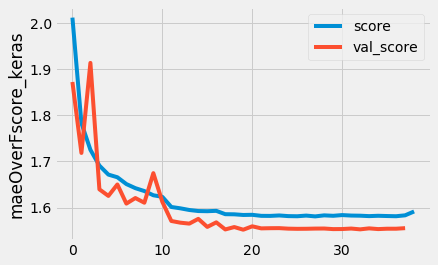

In [33]:
#너무 적어서 과적합 확인 시각화

plt.plot(model.history.history['maeOverFscore_keras'] , label = 'score')
plt.plot(model.history.history['val_maeOverFscore_keras'] , label = 'val_score')
plt.legend()
plt.ylabel('maeOverFscore_keras')
plt.show()


##### loss 시각화

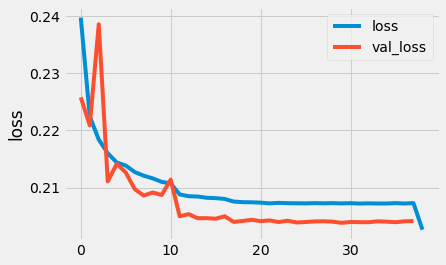

In [79]:
plt.plot(model.history.history['loss'] , label = 'loss')
plt.plot(model.history.history['val_loss'] , label = 'val_loss')
plt.legend()
plt.ylabel('loss')
plt.show()

>- 학습할수록 loss와 val_loss가 동시에 줄어듬을 확인 할 수 있다.

***
***

### 제출 과정

In [60]:
pred_score = str(round(model.history.history['val_maeOverFscore_keras'][-1],2))
print('제출시 예측 결과 점수 : ' , pred_score)

제출시 예측 결과 점수 :  1.56


In [61]:
pred = model.predict(test)
pred.shape

(2416, 40, 40, 1)

In [62]:
submission = pd.read_csv(path + 'sample_submission.csv' , index_col = 0)
submission.head()

,px_1,px_2,px_3,px_4,px_5,px_6,px_7,px_8,px_9,px_10,...,px_1591,px_1592,px_1593,px_1594,px_1595,px_1596,px_1597,px_1598,px_1599,px_1600
id,,,,,,,,,,,,,,,,,,,,,
029858_01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
029858_02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
029858_03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
029858_05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
029858_07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
submission.iloc[:,:] = pred.reshape(-1 , 1600)

In [64]:
from datetime import datetime

pred_score = str(round(model.history.history['val_maeOverFscore_keras'][-1],2))
time = datetime.today().strftime('_%m%d_%H%M')


# 강수량 + 제출시예상점수 + 현재날자.csv
submission.to_csv('강수량' + pred_score  +  time + '.csv')